## <p style="background-color:skyblue; font-family:newtimeroman; font-size:180%; text-align:center">EDA</p>
Code from "[Starter Notebook [A to Z] : Emotion Detection](https://www.kaggle.com/code/pashupatigupta/starter-notebook-a-to-z-emotion-detection)".

### Reading data

In [125]:
import matplotlib.pyplot as plt # plotting
from wordcloud import WordCloud, STOPWORDS
from collections import defaultdict
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [126]:
df = pd.read_csv('./tweet_emotions.csv', delimiter=',')
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


### Basic EDA

In [127]:
def basic_eda(df, row_limit=5, list_elements_limit=10):
    ### rows and columns
    print('Info : There are {} columns in the dataset'.format(df.shape[1]))
    print('Info : There are {} rows in the dataset'.format(df.shape[0]))
    
    print("==================================================")
    
    ## data types
    print("\nData type information of different columns")
    dtypes_df = pd.DataFrame(df.dtypes).reset_index().rename(columns={0:'dtype', 'index':'column_name'})
    cat_df = dtypes_df[dtypes_df['dtype']=='object']
    num_df = dtypes_df[dtypes_df['dtype']!='object']
    print('Info : There are {} categorical columns'.format(len(cat_df)))
    print('Info : There are {} numerical columns'.format(len(dtypes_df)-len(cat_df)))
    
    if list_elements_limit >= len(cat_df):
        print("Categorical columns : ", list(cat_df['column_name']))
    else:
        print("Categorical columns : ", list(cat_df['column_name'])[:list_elements_limit])
        
    if list_elements_limit >= len(num_df):
        print("Numerical columns : ", list(num_df['column_name']))
    else:
        print("Numerical columns : ", list(num_df['column_name'])[:list_elements_limit])
    
    #dtypes_df['dtype'].value_counts().plot.bar()
    display(dtypes_df.head(row_limit))
    
    print("==================================================")
    print("\nDescription of numerical variables")
    
    #### Describibg numerical columns
    desc_df_num = df[list(num_df['column_name'])].describe().T.reset_index().rename(columns={'index':'column_name'})
    display(desc_df_num.head(row_limit))
    
    print("==================================================")
    print("\nDescription of categorical variables")
    
    desc_df_cat = df[list(cat_df['column_name'])].describe().T.reset_index().rename(columns={'index':'column_name'})
    display(desc_df_cat.head(row_limit))
    
    return

In [128]:
basic_eda(df)

Info : There are 3 columns in the dataset
Info : There are 40000 rows in the dataset

Data type information of different columns
Info : There are 2 categorical columns
Info : There are 1 numerical columns
Categorical columns :  ['sentiment', 'content']
Numerical columns :  ['tweet_id']


,column_name,dtype
0,tweet_id,int64
1,sentiment,object
2,content,object



Description of numerical variables


,column_name,count,mean,std,min,25%,50%,75%,max
0,tweet_id,40000.0,1.845184e+09,1.188579e+08,1.693956e+09,1.751431e+09,1.855443e+09,1.962781e+09,1.966441e+09



Description of categorical variables


,column_name,count,unique,top,freq
0,sentiment,40000,13,neutral,8638
1,content,40000,39827,I just received a mothers day card from my lov...,14


In [129]:
# Quickly check for mising values
total = df.isnull().sum()
total

tweet_id     0
sentiment    0
content      0
dtype: int64

### Distribution of sentiments in the data

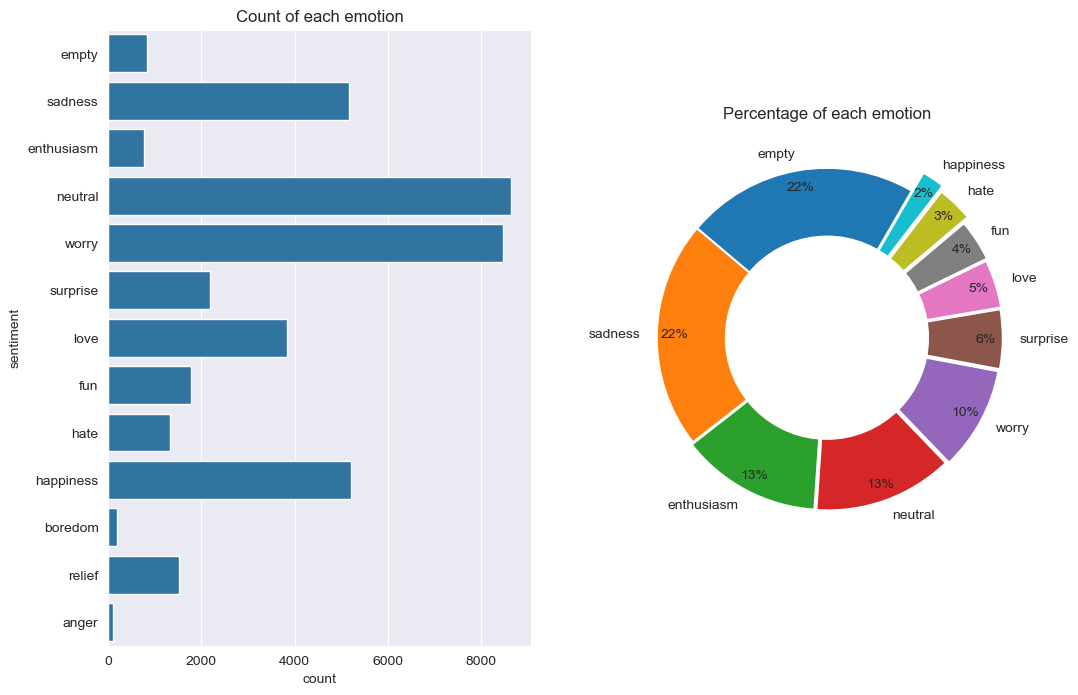

In [130]:
col = 'sentiment'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(df[col].dropna().value_counts()))/sum(list(df[col].dropna().value_counts())))[::-1])[:10]
labels = list(df[col].dropna().unique())[:10]
sizes = df[col].value_counts()[:10]
#ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = df, ax=ax1)
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()
fig.savefig('figures/sample_num_dist_sentiment.png', dpi=300)

### We can see that there are 13 different classes and some of the are having very few examples. (i.e. Anger, Boredom, Empty etc...). This is a very imbalanced dataset and it will not allow the model to converge. We'll reduce the number of classes.
like this

In [131]:
df['sentiment'] = df['sentiment'].apply(lambda x : x if x in ['happiness', 'sadness', 'worry', 'neutral', 'love'] else "other") 

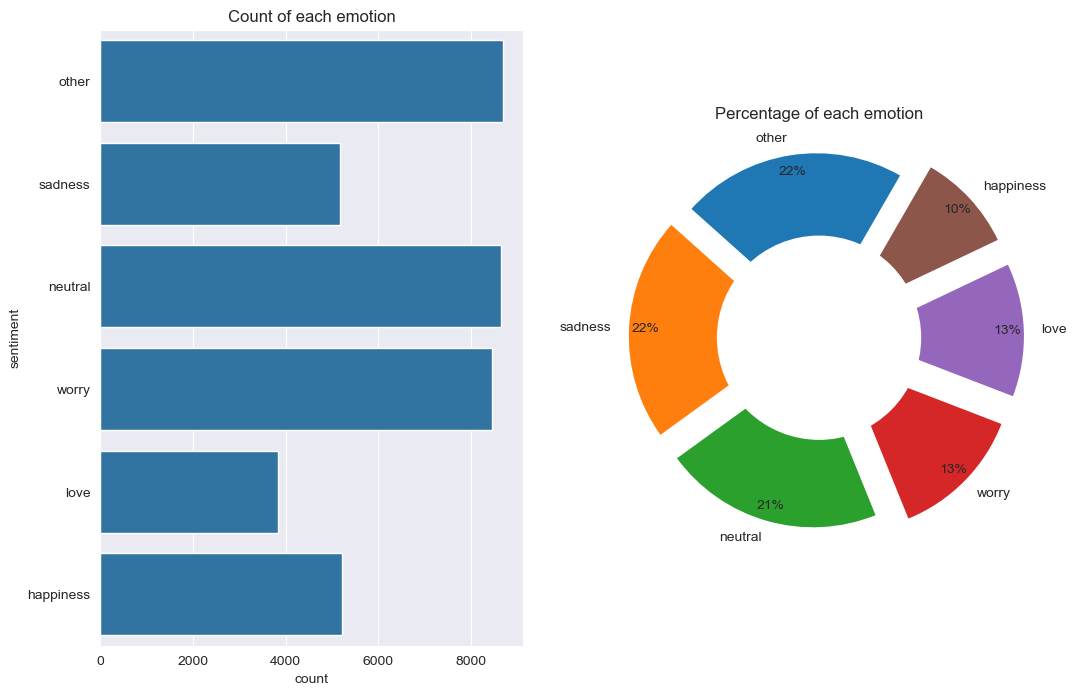

In [132]:
col = 'sentiment'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(df[col].dropna().value_counts()))/sum(list(df[col].dropna().value_counts())))[::-1])[:10]
labels = list(df[col].dropna().unique())[:10]
sizes = df[col].value_counts()[:10]
#ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = df, ax=ax1)
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

Now we are good to go!

In [133]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")
df['char_length'] = df['content'].apply(lambda x : len(x))
df['token_length'] = df['content'].apply(lambda x : len(tokenizer(x)['input_ids']))

### Distribution of character length and token length overall

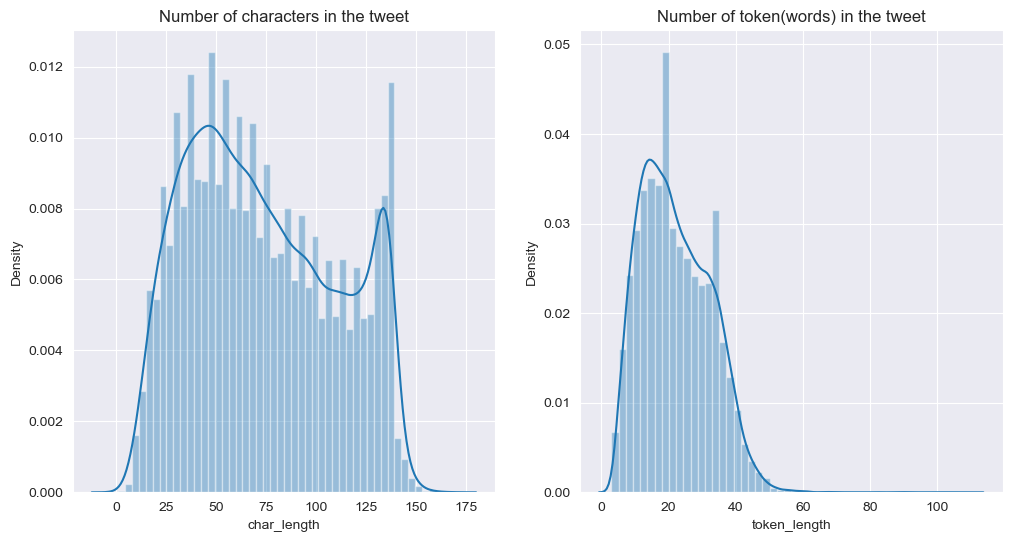

In [134]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.distplot(df['char_length'], ax=ax1)
sns.distplot(df['token_length'], ax=ax2)
ax1.set_title('Number of characters in the tweet')
ax2.set_title('Number of token(words) in the tweet')
plt.show()
fig.savefig('figures/char_token_dist.png', dpi=300)

### Distribution of character length sentiment-wise [Top 5 sentiments]

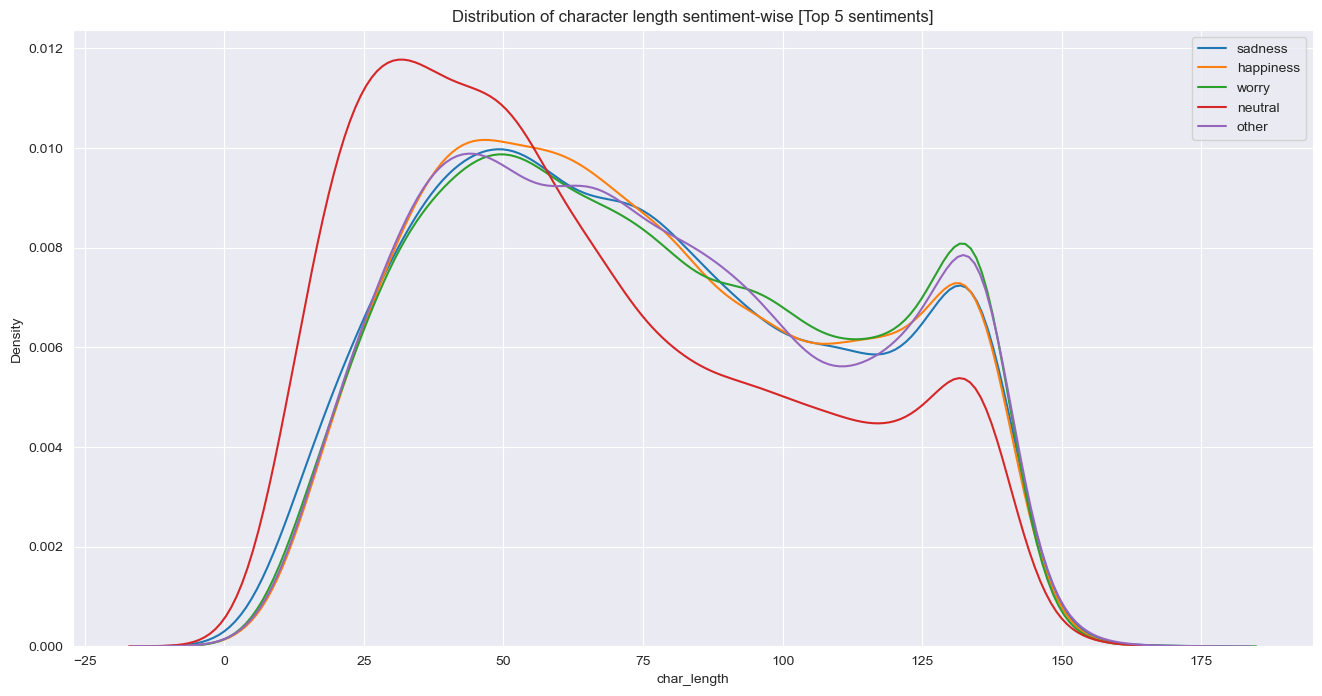

In [135]:
fig, ax = plt.subplots(figsize=(16,8))
for sentiment in df['sentiment'].value_counts().sort_values()[-5:].index.tolist():
    #print(sentiment)
    sns.kdeplot(df[df['sentiment']==sentiment]['char_length'],ax=ax, label=sentiment)
ax.legend()
ax.set_title("Distribution of character length sentiment-wise [Top 5 sentiments]")
plt.show()
fig.savefig('figures/char_dist_sentiment.png', dpi=300)

### Distribution of token length sentiment-wise [Top 5 sentiments]

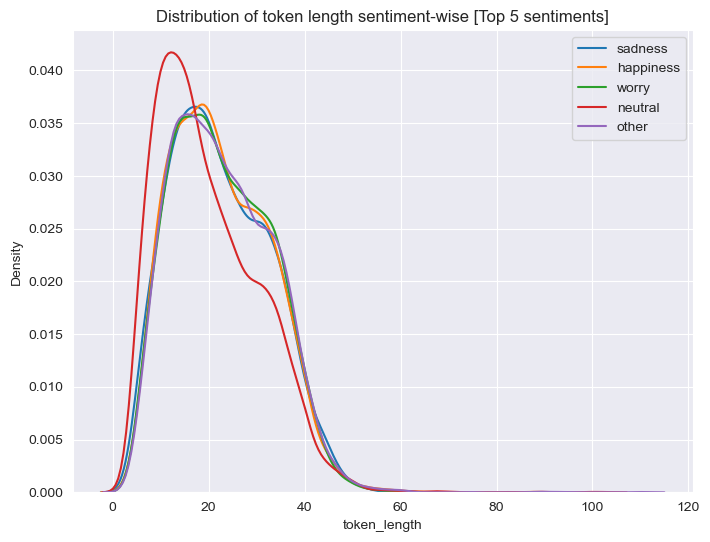

In [136]:
fig, ax = plt.subplots(figsize=(8,6))
for sentiment in df['sentiment'].value_counts().sort_values()[-5:].index.tolist():
    #print(sentiment)
    sns.kdeplot(df[df['sentiment']==sentiment]['token_length'],ax=ax, label=sentiment)
ax.legend()
ax.set_title("Distribution of token length sentiment-wise [Top 5 sentiments]")
plt.show()
fig.savefig('figures/token_dist_sentiment.png', dpi=300)

### Let's look at the most common character and token length

In [137]:
avg_df = df.groupby('sentiment').agg({'char_length':'mean', 'token_length':'mean'})

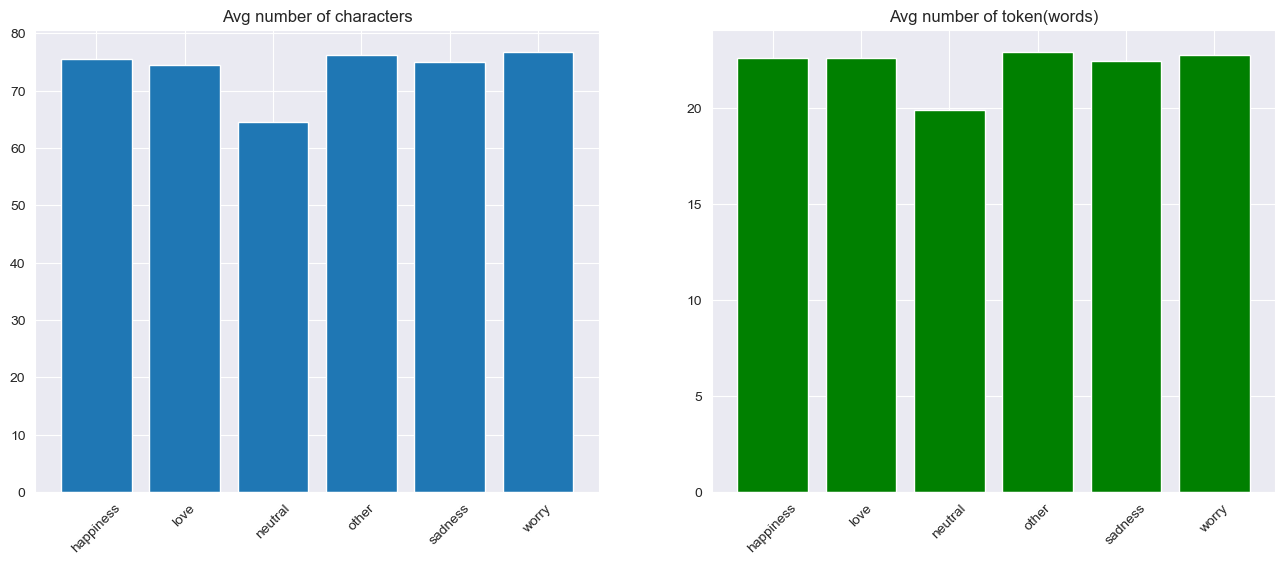

In [138]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1.bar(avg_df.index, avg_df['char_length'])
ax2.bar(avg_df.index, avg_df['token_length'], color='green')
ax1.set_title('Avg number of characters')
ax2.set_title('Avg number of token(words)')
ax1.set_xticklabels(avg_df.index, rotation = 45)
ax2.set_xticklabels(avg_df.index, rotation = 45)
plt.show()
fig.savefig('figures/avg_char_token.png', dpi=300)

Observations 
- There are 13 different emotions.
- "Neurtal" and "Worry" are the most frequent emotions in the dataset.
- Most of the tweets have around 45 characters.
- The most frequent token length is around 10.
- people having "empty" and "neutral" emotion write smaller tweet.

### Uni-gram Analysis

Let's find out the most frequent words in the corpus.

In [139]:
def print_word_cloud(df, sentiment):

    print("Word cloud of most frequent words for the sentiment : {}".format(sentiment))

    temp_df = df[df['sentiment']==sentiment]
    print("Number of Rows : ", len(temp_df))

    corpus = ''
    for text in temp_df.content:
        text = str(text)
        corpus += text

    total = 0
    count = defaultdict(lambda: 0)
    for word in corpus.split(" "):
        total += 1
        count[word] += 1

    top20pairs = sorted(count.items(), key=lambda kv: kv[1], reverse=True)[:20]
    top20words = [i[0] for i in top20pairs]
    top20freq = [i[1] for i in top20pairs]

    xs = np.arange(len(top20words))
    width = 0.5

    fig = plt.figure(figsize=(10,6))
    ax = fig.gca()  #get current axes
    ax.bar(xs, top20freq, width, align='center')

    ax.set_xticks(xs)
    ax.set_xticklabels(top20words)
    plt.xticks(rotation=45)
    fig.savefig('figures/word_bar_{}.png'.format(sentiment), dpi=300)


    stopwords = set(STOPWORDS)
    # lower max_font_size, change the maximum number of word and lighten the background:
    wordcloud = WordCloud(max_font_size=50, max_words=50,stopwords=stopwords, background_color="white").generate(corpus)
    fig = plt.figure(figsize = (12, 12), facecolor = None)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    fig.savefig('figures/word_cloud_{}.png'.format(sentiment), dpi=300)

Word cloud of most frequent words for the sentiment : sadness
Number of Rows :  5165


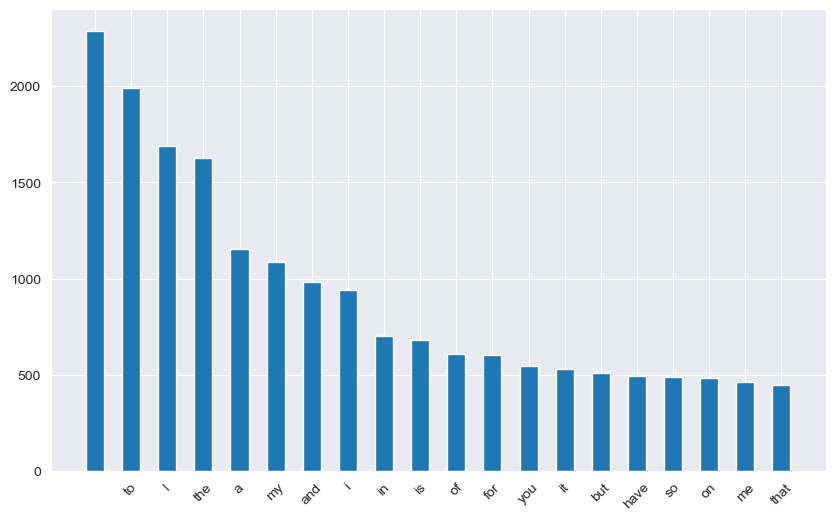

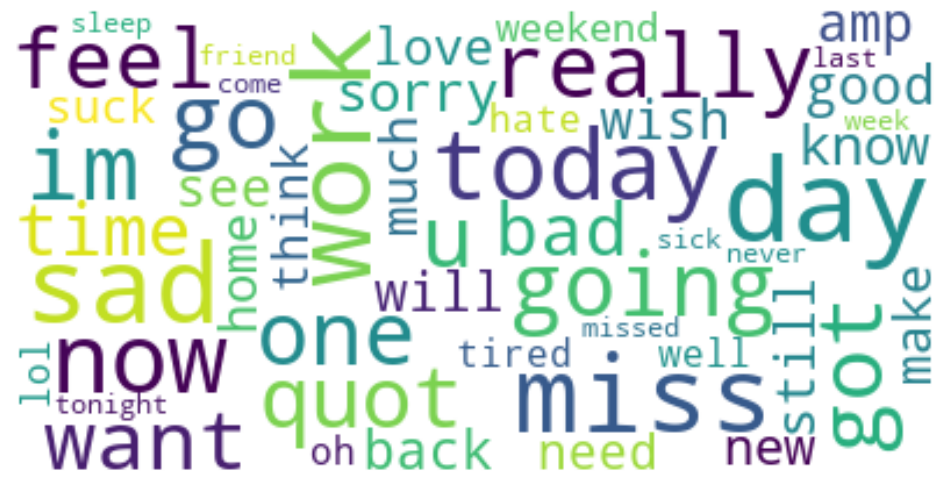

In [140]:
print_word_cloud(df, 'sadness')

Word cloud of most frequent words for the sentiment : happiness
Number of Rows :  5209


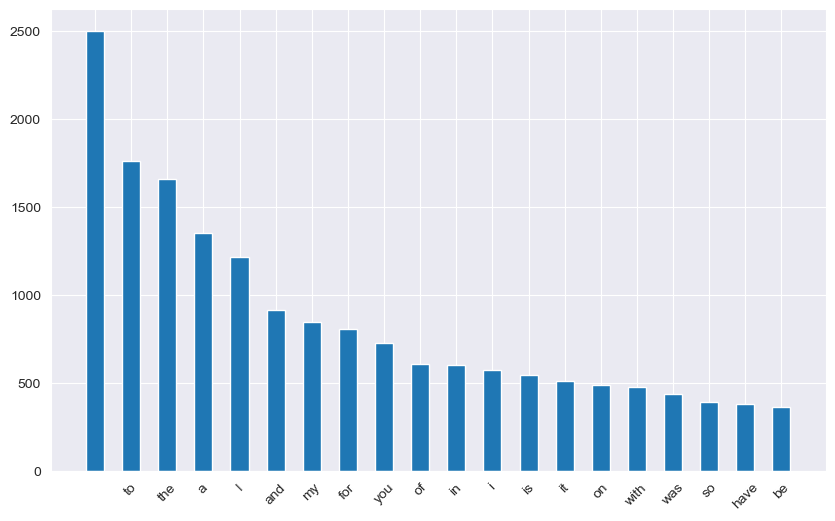

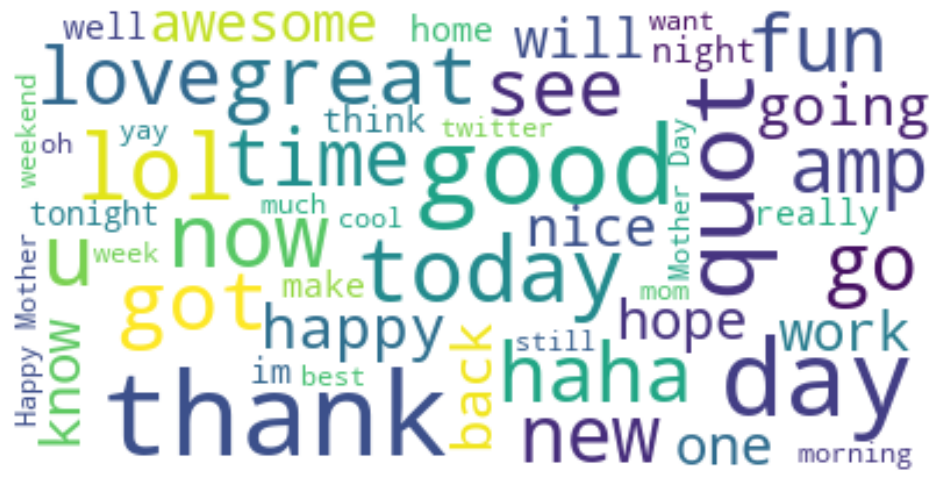

In [141]:
print_word_cloud(df, 'happiness')

The word cloud makes sense as per the emotion